In [418]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [419]:
%reload_ext autoreload

In [420]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import my_types, homography, warp, rectification, utils

In [421]:
DATA = Path("data")

# Pick Correspondences

In [422]:
im1 = my_types.to_img_arr("data/doll1.jpg")
im2 = my_types.to_img_arr("data/doll2.jpg")
im3 = my_types.to_img_arr("data/doll3.jpg")

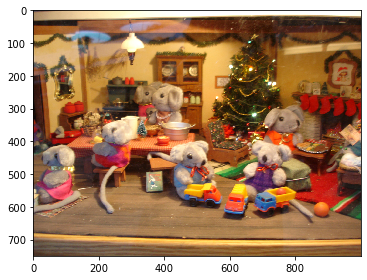

In [423]:
io.imshow(im2)

In [424]:
PICK_NEW = False
im1_name = DATA / "doll1.jpg"
im2_name = DATA / "doll2.jpg"

if PICK_NEW:
    %matplotlib tk
    # im3_name = DATA / "doll3.jpg"
    im1_pts = utils.pick_points(im1_name, 8)
    im2_pts = utils.pick_points(im2_name, 8)
    # im3_pts = utils.pick_points(im3_name, 8)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    # utils.save_points(im3_pts, im3_name)
else:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
    # im3_pts = utils.load_points(im3_name)

In [425]:
im1_pts

array([[710.53896104, 651.69155844],
       [712.56818182, 511.67532468],
       [720.68506494, 398.03896104],
       [864.75974026, 300.63636364],
       [803.88311688, 288.46103896],
       [970.27922078, 499.5       ],
       [588.78571429, 576.61038961],
       [548.2012987 , 462.97402597]])

In [426]:
im2_pts

array([[235.7012987 , 615.16558442],
       [247.87662338, 475.14935065],
       [243.81818182, 365.57142857],
       [393.98051948, 264.11038961],
       [347.30844156, 260.05194805],
       [479.20779221, 442.68181818],
       [124.09415584, 554.28896104],
       [ 69.30519481, 444.71103896]])

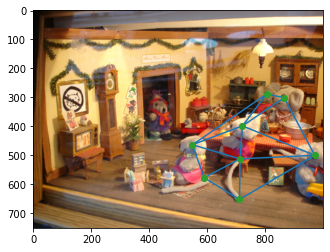

In [427]:
triangulation = warp.delaunay(im1_pts)
warp.plot_tri_mesh(im1, im1_pts, triangulation)

In [428]:
# find homographic transformation matrix
T = homography.homo_matrix(im1_pts, im2_pts)
T

num_pts = 8
(16, 8)
(16,)


array([[ 1.16973903e+00, -4.41763292e-02, -5.34308084e+02],
       [-6.91450044e-03,  1.09612772e+00, -1.11329462e+01],
       [ 2.12107232e-04, -1.93414405e-05,  1.00000000e+00]])

In [429]:
import cv2
T, *_ = cv2.findHomography(im1_pts, im2_pts)
T

array([[ 1.48898902e+00,  5.58042103e-03, -7.22616885e+02],
       [ 7.82864297e-02,  1.41988665e+00, -1.13865899e+02],
       [ 4.46616118e-04,  1.55935124e-04,  1.00000000e+00]])

In [430]:
im1.shape

(750, 1000, 3)

In [431]:
a = T @ np.array([1000, 750, 1]).T
a /= a[2]
a

array([492.82008628, 658.32498042,   1.        ])

In [432]:
homography.bounding_box(im1, T)

[[0, 0], [1000, 0], [0, 750], [1000, 750]]


array([[   0,    0],
       [  89, 1252],
       [ 965,   79],
       [ 772, 1215]])

[[0, 0], [1000, 0], [0, 750], [1000, 750]]
=====src=====
(750, 1000, 3)
0 0
749 999
target_pts.shape = (3, 750000)
====target====
(1449, 1879, 3)
0 0
964 1252
=====interpolate=====
[  0   0   0 ... 772 772 772]
[   0    2    4 ... 1213 1214 1215]


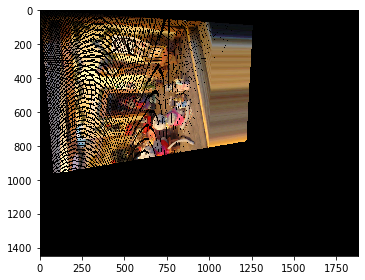

In [446]:
warp1 = homography.forward_warp(im1, T, r=1.5)
io.imshow(warp1)

[[0, 0], [1000, 0], [0, 750], [1000, 750]]
====target====
(966, 1253, 3)
1 2
964 1251
=====src=====
(3, 478580) should be (3, num_pts)
(478580,) (478580,)
(750, 1000, 3)
43 397
714 1087
=====interpolate=====


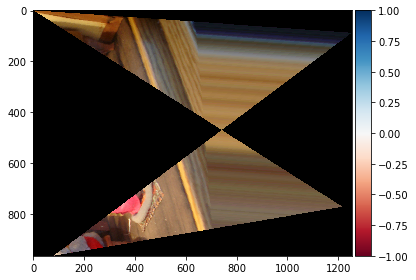

In [455]:
warp1 = homography.inverse_warp(im1, T)
io.imshow(warp1)